# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/dig_img/final_project/NoHand4/'
##change your folder path

In [ ]:
import math
import operator
import sys
from collections import defaultdict

import numpy as np
import cv2

import scipy.spatial as spatial
import scipy.cluster as clstr
import matplotlib.pyplot as plt

import glob
import os
from itertools import combinations

In [ ]:
def canny(img):
    # Maybe add some auto thresholding here
    edges = cv2.Canny(img, 80, 200)
    return edges


def hough_lines(img):
    rho, theta, thresh = 2, np.pi / 180, 600
    return cv2.HoughLines(img, rho, theta, thresh)


def sort_lines(lines):
    """
    Sorts lines by horizontal and vertical
    """
    h = []
    v = []
    for i in range(lines.shape[0]):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v.append([rho, theta])
        else:
            h.append([rho, theta])
    return h, v


def calculate_intersections(h, v):
    """
    Finds the intersection of two lines given in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    """
    points = []
    for rho1, theta1 in h:
        for rho2, theta2 in v:
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            point = np.linalg.solve(A, b)
            point = int(np.round(point[0])), int(np.round(point[1]))
            points.append(point)
    return np.array(points)


def cluster_intersections(points, max_dist=40):
    # I want to change this to kmeans
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), clusters)

    result = []
    for point in clusters:
        result.append([point[0], point[1]])
    return result


def find_chessboard_corners(points):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1))
    return [points[top_left], points[top_right], points[bottom_left], points[bottom_right]]


def distance_between(p1, p2):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def warp_image(img, edges):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    top_left, top_right, bottom_left, bottom_right = edges[0], edges[1], edges[2], edges[3]

    # Explicitly set the data type to float32 or 'getPerspectiveTransform' will throw an error
    warp_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    warp_dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(warp_src, warp_dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))


def cut_chessboard(img, output_path, output_prefix=""):
    side_len = int(img.shape[0] / 8)
    for i in range(8):
        for j in range(8):
            tile = img[i * side_len: (i + 1) * side_len, j * side_len: (j + 1) * side_len]
            cv2.imwrite(output_path + output_prefix + "-" + str(j + i * 8) + ".jpg", tile)


def resize_image(img):
    """
    Resizes image to a maximum width of 800px
    """
    width = img.shape[1]
    if width > 800:
        scale = 800 / width
        return cv2.resize(img, None, fx=scale, fy=scale)
    else:
        return img


def process_chessboard(src_path, output_path, output_prefix="", debug=False, count=0):
    src = cv2.imread(src_path)

    if src is None:
        sys.exit("There is no file with this path!")

    src = resize_image(src)
    src_copy = src.copy()

    # Convert to grayscale
    process = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    if debug:
        plt.imshow(process)
        plt.show()

    # Blur to remove disturbing things
    process = cv2.blur(process, (4, 4))

    if debug:
        plt.imshow(process)
        plt.show()

    # Use Canny Edge Detector https://en.wikipedia.org/wiki/Canny_edge_detector
    process = canny(process)

    if debug:
        plt.imshow(process)
        plt.show()

    # Dilate image (thicker lines)
    process = cv2.dilate(process, np.ones((3, 3), dtype=np.uint8))

    if debug:
        plt.imshow(process)
        plt.show()
    # Use Hough transform to detect lines https://en.wikipedia.org/wiki/Hough_transform
    lines = hough_lines(process)

    # Sort lines by horizontal and vertical
    h, v = sort_lines(lines)

    if debug:
        render_lines(src_copy, h, (0, 255, 0))
        render_lines(src_copy, v, (0, 0, 255))
        plt.imshow(process)
        plt.show()

    if len(h) < 9 or len(v) < 9:
        print("There are not enough horizontal and vertical lines in this image. Try it anyway!")

    # Calculate intersections of the horizontal and vertical lines
    intersections = calculate_intersections(h, v)

    if debug:
        render_intersections(src_copy, intersections, (255, 0, 0), 1)
        plt.imshow(process)
        plt.show()

    # Cluster intersection since there are many
    clustered = cluster_intersections(intersections)

    if debug:
        src_copy = src.copy()
        render_intersections(src_copy, clustered, (255, 0, 0), 5)
        plt.imshow(process)
        plt.show()

    if len(clustered) != 81:
        print("Something is wrong. There are " + str(len(intersections)) + " instead of 81 intersections.")

    # Find outer corners of the chessboard
    corners = find_chessboard_corners(clustered)

    if debug:
        src_copy = src.copy()
        render_intersections(src_copy, corners, (255, 0, 0), 5)
        plt.imshow(process)
        plt.show()

    # Warp and crop image
    dst = warp_image(src, corners)
    try:
        cv2.imwrite(output_path + "crop" + str(count) + ".jpg", dst)
        # print("upload",src_path,"as","crop" + str(count) + ".jpg", dst)
    except:
        print("upload fail")
    # plt.imshow(dst)
    plt.show()
    if debug:
        plt.imshow(process)
        plt.show()

    # Cut chessboard into 64 tiles
    # cut_chessboard(dst, output_path, output_prefix)


def render_lines(img, lines, color):
    for rho, theta in lines:
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(img, pt1, pt2, color, 1, cv2.LINE_AA)


def render_intersections(img, points, color, size):
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), 2, color, size)



# process_chessboard('video_img.png', "output/", "", False)



In [ ]:
def line_intersections(h_lines, v_lines):
  points = []
  for x,[r_h, t_h] in h_lines:
    row = []
    for y,[r_v, t_v] in v_lines:
      a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
      b = np.array([r_h, r_v])
      inter_point = np.linalg.solve(a, b)
      row.append((int(inter_point[0]),int(inter_point[1])))
    points.append(row)
  return np.array(points)

In [ ]:
def plot_grid(image):
  def find_best_9_elements(arr, target_distance):
    best_combination = None
    min_score = float('inf')

    for combination in combinations(arr, 9):
        distances = [combination[i+1][0] - combination[i][0] for i in range(8)]
        score = sum(abs(d - target_distance) for d in distances)

        if score < min_score:
            min_score = score
            best_combination = combination

    return best_combination



  def get_lines(lines,length,isHorizon):
    tmp,res, =[],[]
    for rho, theta in lines:
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a * rho, b * rho
        pts = [int(x0 + 1000 * (-b)), int(y0 + 1000 * a) ,int(x0 - 1000 * (-b)), int(y0 - 1000 * a)]
        if(isHorizon):
          tmp.append([max(pts[1],pts[3]),[rho,theta]])
        else:
          tmp.append([max(pts[0],pts[2]),[rho,theta]])
    tmp.sort()
    mean = length/8
    cur = tmp[0]

    for i in range(len(tmp)):
      if(abs(abs(tmp[i][0]-cur[0])-mean)<=25):
        res.append(cur)
        cur = tmp[i]
      if(i==len(tmp)-1 and len(res)<9):
        res.append(cur)
    if(len(res)<9):
      res = find_best_9_elements(tmp,mean)
    return res

  def locate_board(h,v,r_size,c_size):
    start_point = (v[0],h[0])
    row_length = v[-1]-v[0]
    col_length = h[-1]-h[0]
    return start_point,row_length,col_length



  img = image.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # img = cv2.blur(img, (4, 4))
  img = canny(img)
  img = cv2.dilate(img, np.ones((3, 3), dtype=np.uint8),3)
  # plt.imshow(img)
  # plt.show()
  lines = hough_lines(img)
  h, v = sort_lines(lines)
  h = get_lines(h,image.shape[0],True)
  v = get_lines(v,image.shape[1],False)

  points = line_intersections(h,v)
  # print(points)
  # start_point,row_length,col_length = locate_board(h,v,image.shape[0],image.shape[1])
  # color = (0, 255, 0)  # Green color in BGR
  # radius = 1           # Small radius to represent a point
  # thickness = -1
  # print(points)
  # for i in points:
  #   for j in i:
  #     print(j,end=', ')
  #   print()
  # for row in points:
  #   for point in row:
  #     cv2.circle(image, (int(point[0]),int(point[1])), 20, color, thickness)
  # plt.imshow(image)
  # plt.show()



  table = []
  for i in range(8):
    rr = []
    for j in range(8):
      rr.append([points[i][j][0],points[i][j][1],points[i+1][j+1][0],points[i+1][j+1][1]])
    table.append(rr)
  # print(table)
  # for i in range(8):
  #   row_list = []
  #   for j in range(8):
  #     row_list.append([int(start_point[0]+i*row_length/8), int(start_point[1]+j*col_length/8), int(start_point[0]+(i*row_length/8 )+ (row_length/8)), int(start_point[1]+(j*col_length/8)+(col_length/8))])
  #   table.append(row_list)


  for r in table:
    for pts in r:
      cv2.rectangle(image, (pts[0], pts[1]), (pts[2], pts[3]), (0, 255, 0), 2)

  plt.imshow(image)
  plt.show()
  return table



In [ ]:
!rm -rf "/content/output"
!mkdir "/content/output"
#remove old folder

In [ ]:

# path = "/output"
# os.mkdir(path)

# folder_path = "YOUR_FOLDER_PATH"
output_path = 'output/'


imgs = os.listdir(folder_path)
data = []
for img in imgs:
  if(isinstance(img[4],str)):
    data.append(( int(img[3]),img ))
  else:
    data.append(( int(img[3:5]),img ))
data.sort()


for (cnt,path) in data:
  print(path)
  # if(cnt%2 == 0):
  full_path = folder_path+path
  # img = cv2.imread(full_path)
  # plt.imshow(img)
  # plt.show()
  process_chessboard(full_path, "output/", "", False, cnt)




img1.jpg
Something is wrong. There are 306 instead of 81 intersections.
img2.jpg
Something is wrong. There are 240 instead of 81 intersections.
img3.jpg


<ipython-input-5-ed6d76623909>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))


Something is wrong. There are 256 instead of 81 intersections.
img4.jpg
Something is wrong. There are 289 instead of 81 intersections.


crop3.jpg


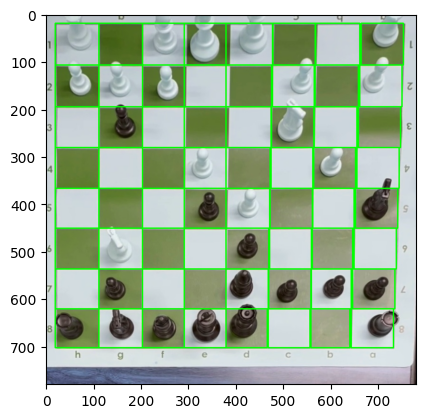

crop2.jpg


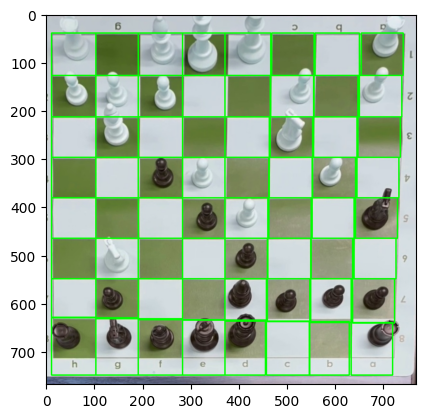

crop1.jpg


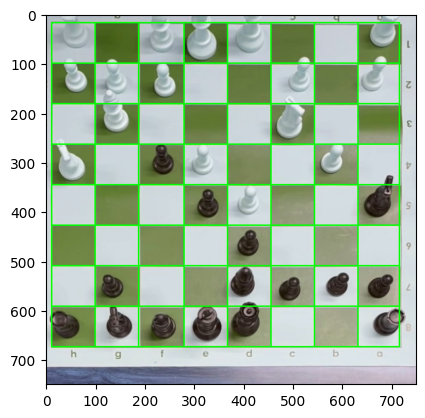

crop4.jpg


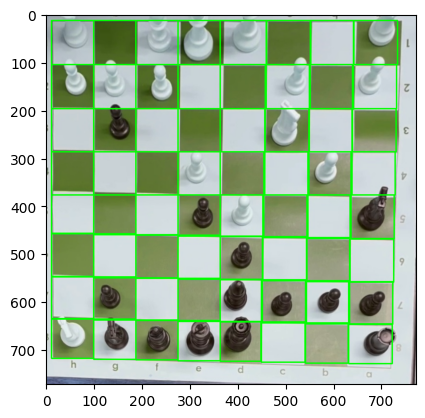

In [ ]:
for path in os.listdir("output/"):
  print(path)
  img = cv2.imread("output/"+path)
  tb = plot_grid(img)
  # print(tb)

In [ ]:
for (cnt,path) in data[0:10]:
  if(cnt%2 == 0):
    full_path = folder_path+path
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img,(3,3),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(th3,cmap='gray')
    plt.show()


In [ ]:
img = cv2.imread("output/crop2.jpg")
table  = plot_grid(img)


In [ ]:
left,right,top,bottom=0,0,0,0

cnt = 0
for i,row in enumerate(table):
  for j,[x1,y1,x2,y2] in enumerate(row):
    crop = img[y1:y2,x1:x2]
    # ret,th = cv2.threshold(crop,0,255,cv2.THRESH_OTSU)
    crop = cv2.blur(crop,(5,5))
    # Calculate histograms for each channel
    hist_r = cv2.calcHist([crop], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([crop], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([crop], [2], None, [256], [0, 256])
    lower_black = (0, 0, 0)
    upper_black = (50, 50, 50)  # Adjust this range based on your image

    # Create a mask
    mask_black = cv2.inRange(crop, lower_black, upper_black)
    # Define ranges for green and white
    lower_green = (0, 100, 0)
    upper_green = (100, 255, 100)

    lower_white = (200, 200, 200)
    upper_white = (255, 255, 255)

    # Create masks for green and white
    mask_green = cv2.inRange(crop, lower_green, upper_green)
    mask_white = cv2.inRange(crop, lower_white, upper_white)

    # Combine masks to exclude green and white
    mask_background = cv2.bitwise_or(mask_green, mask_white)

    # Exclude the background from the black mask
    mask_black_filtered = cv2.bitwise_and(mask_black, cv2.bitwise_not(mask_background))
    hist = cv2.calcHist([mask_black_filtered], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.show()
    # Find contours
    # contours, _ = cv2.findContours(mask_black_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours for visualization
    # result = crop.copy()
    # cv2.drawContours(result, contours, -1, (255, 0, 0), 2)  # Blue contours
    # if(contours):
    #   plt.imshow(mask_black_filtered,cmap='gray')
    #   plt.show()
    #   plt.plot(hist_r)
    #   plt.plot(hist_g)
    #   plt.plot(hist_b)
    #   plt.show()
print(cnt)
